### Imports

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from MALDI_class import MALDI, rawMALDI, binnedMALDI, selectedMALDI
from metaspace_class import metaspace
import os
import nibabel as nib
from sklearn.cluster import KMeans
import skimage.morphology as morph
from sklearn.decomposition import PCA


### Set file parameters

In [2]:
raw_data_folder = '/data/datadata/40_MALDI/MALDI/'
#'/data/pt_02040/MyelinQuantificationProject/raw_data/MALDI/'
background_mask_folder = '/data/datadata/40_MALDI/MALDI/coregistration/'
#'/data/pt_02040/MyelinQuantificationProject/coregistration/'

results_folder = 'expdata/final/'
#'/data/pt_02040/MyelinQuantificationProject/results_final/
if not os.file.ifile(results_folder + 'samples.csv'):
    raise ValueError('provide samples.csv in results folder with sample names in raw_data_folder without imzML extension')
    
samples = np.loadtxt(results_folder + 'samples.csv', dtype = str)#pattern: 'brain{sample}re_{section}_{ROI}
paths = np.array([raw_data_folder + samples[i].split('_')[0] + '-' + samples[i].split('_')[1] + '/' + samples[i].split('_')[2] + '/RAW-Data/' + samples[i].split('_')[0] + '-' + samples[i].split('_')[1] + '_' + samples[i].split('_')[2] + '_pos' + '.imzML' for i in range(len(samples))])


#REMOVE FROM HERE
for sample_index in range(len(samples)):
    if not os.path.isfile(paths[sample_index]):
        paths[sample_index] = paths[sample_index].split('.')[0] + '_validated.' + paths[sample_index].split('.')[1]
    if not os.path.isfile(paths[sample_index].split('.')[0] + '.ibd'):
        paths[sample_index] = None
        samples[sample_index] = None
paths = paths[samples != 'None']
samples = samples[samples != 'None']
#samples = np.array([samples[0]])
#paths = np.array([paths[0]])
samples = samples[:1]
paths = paths[:1]
#REMOVE UNTIL HERE
print(samples)

['brain201re_49_V1']


### Set MALDI data parameters

In [3]:
MALDI_parameters = {
	'resolution' : 1e-5,		#ppm
	'accuracy' : 2.5e-6,
    'global_range' : (400., 1000.),
	'normalize' : 'tic',
    'n_processes' : 1, 
    'n_clusters' : 3
}
MALDI_results = {
}

### Set METASPACE parameters

In [4]:
### Database parameters ###
name = results_folder + 'metaspacefiltering'

metaspaceparams = {
	'databases' : ['HMDB', 'SwissLipids', 'LipidMaps'],
	'max_fdr' : .05,
    'api_key' : 'vxBtcaq839qX'
	}

### Matrix reference measurement parameters ###
matrixproject = 'b9195154-ba0d-11eb-96db-bbe19b6ae1a2'
matrixdataset = ['2021-05-21_10h24m13s', '2021-06-09_13h10m10s', '2021-07-02_15h25m26s']

### SAMPLE IDENTIFIERS FOR OLD, GREY NEW AND BRIGHT NEW DATA ###
project_id = '7b876960-ecbc-11ec-89bf-5b32557b3a87'
dataset_ids = ['2020-11-16_10h33m20s', '2020-11-16_11h12m42s', '2020-11-16_11h13m38s', '2020-11-16_11h15m09s', '2020-11-16_11h18m12s', '2020-11-16_11h21m21s', '2020-11-16_11h23m40s', '2022-04-22_13h50m55s', '2022-04-22_13h53m22s', '2022-04-22_13h43m51s', '2022-04-22_13h58m27s', '2022-04-22_13h57m25s', '2022-04-22_13h59m24s', '2022-04-22_14h00m05s']


### Get matrix annotations

In [5]:
matrix = metaspace(matrixdataset, databases = metaspaceparams['databases'], proj_id = matrixproject, api_key = metaspaceparams['api_key'])
matrix.get_datasets(drop_duplicates = False, sort_by = ['mz'])
matrixmzs = np.unique(matrix.data.mz.values)
#manually selected matrix ions
matrixions = ['C24H49NO3+H+', 'C27H46O4+Na+', 'C47H79NO8+Na+', 'C42H82NO11P+H+', 'C49H83NO8+Na+', 'C19H14O9+Na+', 'C10H15N5O9P2+H+', 'C24H40O4+Na+', 'C24H50NO7P+K+', 'C30H58NO10P+H+', 'C38H77NO4+Na+', 'C31H60NO10P+H+', 'C42H81NO3+H+', 'C32H62NO10P+H+', 'C40H81NO4+Na+', 'C41H83NO5+Na+', 'C37H71O8P+K+', 'C40H66O12+H+', 'C41H77O8P+K+', 'C43H76NO7P+Na+', 'C45H78NO7P+Na+', 'C42H81O10P+Na+', 'C45H80NO7P+Na+', 'C47H82NO7P+Na+', 'C46H90NO10P+H+', 'C47H93N2O6P+K+', 'C47H92NO8P+Na+', 'C46H90NO11P+H+', 'C48H94NO7P+K+', 'C20H36O2+H+', 'C20H43NO+H+', 'C21H36O5+Na+', 'C25H46O2+Na+', 'C23H47NO4+H+', 'C22H28O6+Na+', 'C30H50+Na+', 'C36H75N+H+', 'C26H54NO7P+H+', 'C40H81NO3+Na+', 'C42H81NO3+H+', 'C33H64NO9P+H+', 'C33H64NO10P+H+', 'C35H68NO9P+H+', 'C33H64NO10P+Na+', 'C35H68NO10P+Na+', 'C41H72O10+H+', 'C41H83N2O6P+H+', 'C23H34O5+H+', 'C27H44O2+H+', 'C26H38O4+H+', 'C37H70O12S+H+', 'C40H80NO8P+K+', 'C42H82NO8P+K+', 'C42H84NO8P+K+', 'C44H86NO8P+K+', 'C49H90NO8P+H+', 'C46H92NO11P+H+', 'C39H73O8P+K+', 'C45H74NO7P+H+']

### Get tissue annotations

In [6]:
mydataset = metaspace(dataset_ids, databases = metaspaceparams['databases'], proj_id = project_id, api_key = metaspaceparams['api_key'])

### Set filter parameters

In [7]:
filterparams = {
	'drop_duplicates' : False,
	'msm' : [.8],		#values for msm score threshold to evaluate
	'appearances' : [0],		#number of datasets a peak must appear in
	'force_dataset' : [None],		#datasets a peak must appear in at least on of
	'matrixmzs' : matrixmzs,		#List of matrix mz values to remove from the peaklist
	'matrixions' : matrixions,		#List of matrix ion names to remove from the peaklist
	'removerange' : 10e-6,
	'mzrange' : [400,1000]
}

### Filter annotations according to filterparameters and store the results in a csv table and overview figure

In [8]:
for msm in filterparams['msm']:
	for appearances in filterparams['appearances']:
		for force_dataset in filterparams['force_dataset']:
			print(appearances, msm, force_dataset)

			### GET DATASETS ###
			mydataset.get_datasets(drop_duplicates = filterparams['drop_duplicates'], sort_by = ['mz'])
			mydataset.data.sort_values(['mz'], inplace = True)

			### FILTER BY MSM ###
			mydataset.filter_by(parameters = ['msm'], values = [str(msm)], operators = ['>'])
			name += '_msm>' + str(msm)
			print('filter by msm>' + str(msm) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### FILTER BY APPEARANCE ###
			val, ind, counts = np.unique(mydataset.data.mz.values, return_index = True, return_counts = True)
			mydataset.data = mydataset.data[mydataset.data.mz.isin(val[counts>appearances])]
			name += '_appearance=' + str(appearances)
			print('filter by appearance=' + str(appearances) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### FILTER BY SINGLE DATASET ###
			if force_dataset is not None:
				mydataset.filter_by(parameters = ['dataset'], values = [str(force_dataset)], operators = ['=='])
				name += '_force_dataset=' + str(force_dataset)
				print('filter by force_dataset=' + str(force_dataset) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### DROP DUPLICATES ###
			mydataset.data.drop_duplicates(subset = ['ionFormula', 'ion'], inplace = True)		#remove resulting duplicates
			print('drop_duplicates' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### FILTER BY MATRIX MEASUREMENT ###
			if filterparams['matrixmzs'] is not None:
				mydataset.data = mydataset.data[~mydataset.data['mz'].isin(filterparams['matrixmzs'])]
				print('filter by matrixmzs' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
				mydataset.data = mydataset.data[~mydataset.data['ion'].isin(filterparams['matrixions'])]
				name += '_matrixmzs'
				print('filter by matrixmzs and matrixions' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### remove in 10ppm range ###
			if filterparams['removerange'] is not None:
				mydataset.filter_neighboring_mzs(rrange = filterparams['removerange'])
				name += '_removed' + str(filterparams['removerange'])
				print('filter by removerrange' + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')

			### FILTER BY mzrange ###
			mydataset.filter_by(parameters = ['mz'], values = [str(filterparams['mzrange'][0])], operators = ['>'])
			mydataset.filter_by(parameters = ['mz'], values = [str(filterparams['mzrange'][1])], operators = ['<'])
			name += '_mzrange>' + str(filterparams['mzrange'])
			print('filter by msm>' + str(filterparams['mzrange']) + ' reduced to ' + str(np.unique(mydataset.data.mz.values).shape) + ' entries')
			#mydataset.data.to_csv(name + '.csv')

			### STORE DATA ###
			mydataset.data.insert(0, 'index', np.arange(1,mydataset.data.shape[0]+1))
			mydataset.data.to_csv(name + '.csv', columns = ['index', 'ionFormula', 'ion', 'mz', 'msm', 'rhoSpatial', 'rhoSpectral', 'moc', 'fdr', 'moleculeNames', 'moleculeGroups'])
			MALDI_results['selected_mzs'] = np.unique(mydataset.data.mz.values)
			n_peaks = len(MALDI_results['selected_mzs'])

0 0.8 None
filter by msm>0.8 reduced to (249,) entries
filter by appearance=0 reduced to (249,) entries
drop_duplicates reduced to (177,) entries
filter by matrixmzs reduced to (163,) entries
filter by matrixmzs and matrixions reduced to (114,) entries
filter by removerrange reduced to (80,) entries
filter by msm>[400, 1000] reduced to (76,) entries


### Iterate through samples and process MALDI Data

In [9]:
MALDI_results['shape'] = []
MALDI_results['TIC'] = []
MALDI_results['center_of_mass'] = []
MALDI_results['mzmaps'] = []
MALDI_results['all_background_data'] = np.zeros((0,n_peaks))
MALDI_results['all_tissue_data'] = np.zeros((0,n_peaks))
MALDI_results['all_data'] = np.zeros((0,n_peaks))
for sample_index in range(len(samples)):
    ### LOAD DATA ###
    if not os.path.isfile(paths[sample_index]):
        paths[sample_index] = paths[sample_index].split('.')[0] + '_validated.' + paths[sample_index].split('.')[1]
    M = MALDI(paths[sample_index], resolution = MALDI_parameters['resolution'], n_processes = MALDI_parameters['n_processes'])
    print('number of pixels', len(M.indices))
    print('image shape', M.shape)
    ### GET RAW DATA ###
    M_raw = rawMALDI(M.filename, M.resolution, M.range_, M.n_processes)
    print('mass range', M_raw.range_)
    MALDI_results['shape'].append(M_raw.shape)
    ### NORMALIZE DATA ###
    MALDI_results['TIC'].append(M_raw.normalize(algorithm = MALDI_parameters['normalize'], return_map = True))
    ### CALCULATE CENTER OF MASS ###
    MALDI_results['center_of_mass'].append(M_raw.center_of_mass(massrange = (550,900)))
    ### CALCULATE MZ MAPS ###
    imgstack = np.zeros((M.shape[0], M.shape[1], n_peaks))
    for peak in range(n_peaks):
        imgstack[:,:,peak] = M_raw.get_2D(M_raw.massvec(MALDI_results['selected_mzs'][peak]))
    MALDI_results['mzmaps'].append(imgstack)
    ### LOAD INITIAL BACKGROUND MASKS ###
    mask = nib.load(background_mask_folder + samples[sample_index].split('_')[0] + '/inputs/' + 'MALDI_' + samples[sample_index].split('_')[0] + '_' + samples[sample_index].split('_')[1] + '_' + samples[sample_index].split('_')[2] + '_background_mask.nii.gz').get_fdata()
    MALDI_results['all_background_data'] = np.append(MALDI_results['all_background_data'], imgstack[mask[:,:,0]!=0, :], axis = 0)
    MALDI_results['all_tissue_data'] = np.append(MALDI_results['all_tissue_data'], imgstack[mask[:,:,0]==0, :], axis = 0)
    MALDI_results['all_data'] = np.append(MALDI_results['all_data'], imgstack.reshape(M.shape[0]*M.shape[1], n_peaks), axis = 0)
    
    

/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updati

number of pixels 5229
image shape [63 83]
mass range (300.0013371474396, 1001.5039132578256)


### Calculate mask

In [10]:
background_init_cluster = np.mean(MALDI_results['all_background_data'], axis = 0)
tissue_init_cluster = KMeans(random_state = 1234, n_clusters =  MALDI_parameters['n_clusters']-1).fit(MALDI_results['all_tissue_data'])
full_init_cluster = np.append(background_init_cluster, tissue_init_cluster.cluster_centers_).reshape(MALDI_parameters['n_clusters'], n_peaks)
final_cluster = KMeans(random_state = 1234, n_clusters =  MALDI_parameters['n_clusters'], init = full_init_cluster).fit(MALDI_results['all_data'])




/home/sj/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


In [11]:
MALDI_results['cluster_maps'] = []
for sample_index in range(len(samples)):
    mask = nib.load(background_mask_folder + samples[sample_index].split('_')[0] + '/inputs/' + 'MALDI_' + samples[sample_index].split('_')[0] + '_' + samples[sample_index].split('_')[1] + '_' + samples[sample_index].split('_')[2] + '_background_mask.nii.gz').get_fdata()
    image = final_cluster.predict(MALDI_results['mzmaps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1], n_peaks)).reshape(MALDI_results['shape'][sample_index])
    opened = morph.area_opening(image, 4)
    cluster_map = morph.area_closing(opened, 4)
    cluster_map[mask[:,:,0]!=0] = 0
    MALDI_results['cluster_maps'].append(cluster_map)
    ### MAPPING ###
    #final = np.copy(closedopened)
    #final[final == 2] = 3
    #final[final == 1] = 2
    #final[final == 0] = 1
    #final[final == 3] = 0

### Get region spectra and calculate PCA

In [63]:
MALDI_results['mean_spectrum'] = []
MALDI_results['mean_white_matter_spectrum'] = []
MALDI_results['mean_cortex_spectrum'] = []
MALDI_results['masked_mzmaps'] = []
MALDI_results['standardized_masked_mzmaps'] = []
MALDI_results['mean_img'] = []
MALDI_results['pca'] = []
MALDI_results['bins'] = []
MALDI_results['bincenters'] = []
for sample_index in range(len(samples)):
    ### LOAD DATA ###
    if not os.path.isfile(paths[sample_index]):
        paths[sample_index] = paths[sample_index].split('.')[0] + '_validated.' + paths[sample_index].split('.')[1]
    M = MALDI(paths[sample_index], resolution = MALDI_parameters['resolution'], n_processes = MALDI_parameters['n_processes'], range_ = MALDI_parameters['global_range'])
    ### GET RAW DATA ###
    M_raw = rawMALDI(M.filename, M.resolution, M.range_, M.n_processes)
    ### NORMALIZE DATA ###
    M_raw.normalize(algorithm = MALDI_parameters['normalize'])
    ### CALCULATE BINNED DATA ###
    M_binned = binnedMALDI(M.filename, M.resolution, M.range_, M.n_processes, data_spectrum = M_raw.data_spectrum)
    MALDI_results['bins'].append(M_binned.bins)
    MALDI_results['bincenters'].append(M_binned.bincenters)
    ### CALCULATE MEAN SPECTRA for full measurement and tissue regions ###
    MALDI_results['mean_spectrum'].append(np.mean(M_binned.data_histo, axis = 0))
    MALDI_results['mean_cortex_spectrum'].append(np.mean(M_binned.data_histo[MALDI_results['cluster_maps'][sample_index][M.map2D[:,0], M.map2D[:,1]] == 1], axis = 0))
    MALDI_results['mean_white_matter_spectrum'].append(np.mean(M_binned.data_histo[MALDI_results['cluster_maps'][sample_index][M.map2D[:,0], M.map2D[:,1]] == 2], axis = 0))
  
    ### MASK BACKGROUND ###
    MALDI_results['masked_mzmaps'].append(np.copy(MALDI_results['mzmaps'][sample_index]))
    MALDI_results['masked_mzmaps'][sample_index][MALDI_results['cluster_maps'][sample_index] == 0, :] = None
    MALDI_results['masked_mzmaps'][sample_index] = MALDI_results['masked_mzmaps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1], n_peaks)
    ### MEAN IMAGE OF PEAKMAPS ###
    MALDI_results['mean_img'].append(np.sum(MALDI_results['masked_mzmaps'][sample_index], axis = 1))    
    ### STANDARDIZE PEAKMAPS ###
    MALDI_results['standardized_masked_mzmaps'].append((MALDI_results['masked_mzmaps'][sample_index] - np.nanmean(MALDI_results['masked_mzmaps'][sample_index], axis = 0)) / np.nanstd(MALDI_results['masked_mzmaps'][sample_index], axis = 0))

    ### CALCULATE PCA ###
    MALDI_results['pca'].append(PCA(n_components = n_peaks).fit(MALDI_results['standardized_masked_mzmaps'][sample_index][MALDI_results['cluster_maps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1]) != 0, :]))
    

    
    

/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updati

### PRINT AND STORE EVERYTHING

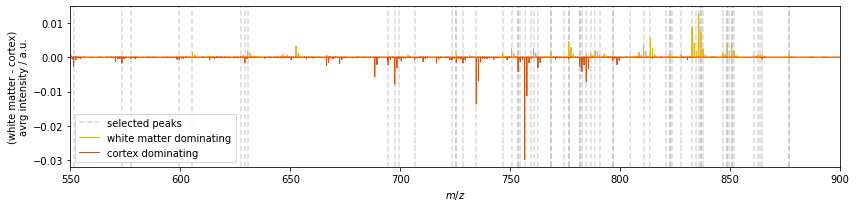

/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000563 found with incorrect name "Thermo RAW file". Updating name to "Thermo RAW format".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession MS:1000590 found with incorrect name "contact organization". Updating name to "contact affiliation".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000042 found with incorrect name "max count of pixel x". Updating name to "max count of pixels x".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000043 found with incorrect name "max count of pixel y". Updating name to "max count of pixels y".
  warn(
/home/sj/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updati

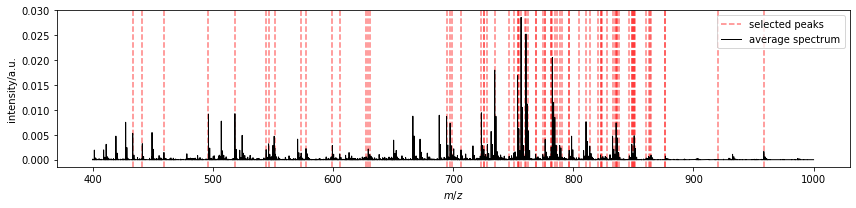

In [71]:
white_matter_color = '#EDB120'
cortex_color = '#D95319'
from matplotlib.colors import ListedColormap

cmap = ListedColormap(['#0072BD', '#D95319', '#EDB120'])

center_of_mass_limits = (680, 790)
if not os.file.isdir(results_folder + 'peakmaps/'):
    os.mkdir(results_folder + 'peakmaps/')
if not os.file.isdir(results_folder + 'peakmaps/'):
    os.mkdir(results_folder + 'pca/')

### PLOT REGION DIFFERENCE IN MASS DISTRIBUTION ###
plt.figure(figsize = (12,3))
diffs = np.mean(MALDI_results['mean_white_matter_spectrum'], axis = 0)-np.mean(MALDI_results['mean_cortex_spectrum'], axis = 0)
for peak in MALDI_results['selected_mzs'][:-1]:
    plt.axvline(peak, linestyle = '--', color = 'grey', alpha = .3)
plt.axvline(MALDI_results['selected_mzs'][-1], linestyle = '--', color = 'grey', label = 'selected peaks', alpha = .3)
plt.plot(MALDI_results['bincenters'][0][diffs>0], diffs[diffs>0], linewidth = 1., color = white_matter_color, label = 'white matter dominating')
plt.plot(MALDI_results['bincenters'][0][diffs<0], diffs[diffs<0], linewidth = 1., color = cortex_color, label = 'cortex dominating')
plt.xlabel('$m/z$')
plt.ylabel('(white matter - cortex)\navrg intensity / a.u.')
plt.xlim((550, 900))
plt.legend(loc = 'best')
plt.tight_layout()
plt.savefig(results_folder + 'white-greyspec' + '_.png', transparent = True)
plt.show()

for sample_index in range(len(samples)):
    M = MALDI(paths[sample_index], resolution = MALDI_parameters['resolution'], n_processes = MALDI_parameters['n_processes'], range_ = MALDI_parameters['global_range'])

    ### PLOT MEAN SPECTRUM ###
    plt.figure(figsize = (12,3))
    for peak in MALDI_results['selected_mzs'][:-1]:
        plt.axvline(peak, linestyle = '--', color = 'r', alpha = .5)
    plt.axvline(MALDI_results['selected_mzs'][-1], linestyle = '--', color = 'r', label = 'selected peaks', alpha = .5)
    plt.plot(MALDI_results['bincenters'][sample_index], MALDI_results['mean_spectrum'][sample_index], linewidth = 1., color = 'k', label = 'average spectrum')
    plt.xlabel('$m/z$')
    plt.ylabel('intensity/a.u.')
    plt.legend(loc = 'best')
    plt.tight_layout()
    plt.savefig(results_folder + samples[sample_index] + '_meanspec.png', transparent = True)
    plt.show()    

    ### PLOT TOTAL ION CURRENT MAP ###
    plt.imsave(results_folder + samples[sample_index] + '_TIC.png', np.log(M.get_2D(MALDI_results['TIC'][sample_index]/np.mean(MALDI_results['TIC'][sample_index]))), vmin =np.log(1/5), vmax =np.log(1*5), cmap = 'coolwarm')

    ### PLOT CENTER OF MASS MAP ###
    min_ = np.nanmin(MALDI_results['center_of_mass'][sample_index])
    com_image = M.get_2D(MALDI_results['center_of_mass'][sample_index])
    com_image[MALDI_results['cluster_maps'][sample_index] == 0] = min_
    plt.imsave(results_folder + samples[sample_index] + '_center_of_mass.png', com_image, vmin = center_of_mass_limits[0], vmax = center_of_mass_limits[1])
    plt.imshow(com_image, vmin = center_of_mass_limits[0], vmax = center_of_mass_limits[1])
    plt.show()

    ### PLOT AND STORE SELECTED PEAK MAPS ###
    for peak in range(5):#len(MALDI_results['selected_mzs'])):
        img = MALDI_results['masked_mzmaps'][sample_index][:,peak].reshape(MALDI_results['shape'][sample_index][0], MALDI_results['shape'][sample_index][1])
        img_standardized = MALDI_results['standardized_masked_mzmaps'][sample_index][:,peak].reshape(MALDI_results['shape'][sample_index][0], MALDI_results['shape'][sample_index][1])
        #img[np.isnan(img)] = np.nanmin(img)
        #img_standardized[np.isnan(img_standardized)] = np.nanmin(img_standardized)
        plt.imsave(results_folder + 'peakmaps/' + samples[sample_index] + '_mz' + str(peak+1).zfill(2) + '_view.png', img)
        plt.imsave(results_folder + 'peakmaps/' + samples[sample_index] + '_mz' + str(peak+1).zfill(2) + '_view_standardized.png', img_standardized)
        np.savetxt(results_folder + 'peakmaps/' + samples[sample_index] + '_mz' + str(peak+1).zfill(2) + '_map.csv', img, delimiter = ',')
        np.savetxt(results_folder + 'peakmaps/' + samples[sample_index] + '_mz' + str(peak+1).zfill(2) + '_map_standardized.csv', img_standardized, delimiter = ',')
    
    ### PLOT AND STORE MASK MAP ###
    plt.imsave(results_folder + samples[sample_index] + '_mask.png', MALDI_results['cluster_maps'][sample_index], cmap = cmap)
    np.savetxt(results_folder + samples[sample_index] + '_mask.csv', MALDI_results['cluster_maps'][sample_index], delimiter = ',')
    plt.imshow(MALDI_results['cluster_maps'][sample_index], cmap = cmap))
    plt.show()
    
    ### PLOT AND STORE 1st AND 2nd PCA COMPONENTS AND EXPLAINED VAIANCE ###
    results = np.zeros((MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1], n_peaks))
    results[MALDI_results['cluster_maps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1]) != 0,:] = MALDI_results['pca'][sample_index].transform(MALDI_results['standardized_masked_mzmaps'][sample_index][MALDI_results['cluster_maps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1]) != 0])

    if np.corrcoef(results[MALDI_results['cluster_maps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1]) != 0,0], MALDI_results['mean_img'][sample_index][MALDI_results['cluster_maps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1]) != 0,])[0,1] < 0:
        components0 = -1*MALDI_results['pca'][sample_index].components_[0,:]
        pcamap0 = -1*results[:,0].reshape((MALDI_results['shape'][sample_index][0], MALDI_results['shape'][sample_index][1]))
    else:
        components0 = MALDI_results['pca'][sample_index].components_[0,:]
        pcamap0 = results[:,0].reshape((MALDI_results['shape'][sample_index][0], MALDI_results['shape'][sample_index][1]))
    if np.corrcoef(results[MALDI_results['cluster_maps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1]) != 0,1], MALDI_results['mean_img'][sample_index][MALDI_results['cluster_maps'][sample_index].reshape(MALDI_results['shape'][sample_index][0]*MALDI_results['shape'][sample_index][1]) != 0,])[0,1] < 0:
        components1 = -1*MALDI_results['pca'][sample_index].components_[1,:]
        pcamap1 = -1*results[:,1].reshape((MALDI_results['shape'][sample_index][0], MALDI_results['shape'][sample_index][1]))
    else:
        components1 = MALDI_results['pca'][sample_index].components_[1,:]
        pcamap1 = results[:,1].reshape((MALDI_results['shape'][sample_index][0], MALDI_results['shape'][sample_index][1]))
    ev = MALDI_results['pca'][sample_index].explained_variance_
    
    plt.imsave(results_folder + 'pca/' + samples[sample_index] + '_map1.png', pcamap0)
    plt.imsave(results_folder + 'pca/' + samples[sample_index] + '_map2.png', pcamap1)
    np.savetxt(results_folder + 'pca/' + samples[sample_index] + '_map1.csv', pcamap0, delimiter = ',')
    np.savetxt(results_folder + 'pca/' + samples[sample_index] + '_components1.csv', components0, delimiter = ',')
    np.savetxt(results_folder + 'pca/' + samples[sample_index] + '_map2.csv', pcamap1, delimiter = ',')
    np.savetxt(results_folder + 'pca/' + samples[sample_index] + '_components2.csv', components1, delimiter = ',')
    np.savetxt(results_folder + 'pca/' + samples[sample_index] + '_ev.csv', ev, delimiter = ',')
    plt.show(pcamap0)
    plt.imshow()
### STORE GENERAL DICT ###
np.save(results_folder + 'MALDI_results.npy', MALDI_results)
np.save(results_folder + 'MALDI_parameters.npy', MALDI_parameters)